**Проект спринта "Принятие решений в бизнесе".**

# Вступление

Наш интернет_магазин является одним из крупнейших на рынке в своей категории. Для дальнейшей успешной работы, привлечения новых пользователей и увеличения прибыли отделом аналитика совместно с отделом маркетинга были предложены ряд гипотез.

В этой работе мы проанализируем предоженные гипотезы по улучшению показателей деятельности компании, проведем их приоритезацию и определим, какие из них можно отправить на дальнейшую проработку.

Также нами был проведен А/В-тест одной из гипотез. В этом проекте мы проанализируем полученные в ходе А/В-теста данные и попятаемся принять решение о дальнейших действиях.

# Содержание: 

1. Приоритезация гипотез.

  1.1. Обзор данных для приоритезации гипотез;
  
  1.2. Приоритезация гипотез с помощью фреймворка `ICE`;
  
  1.3. Приоритезация гипотез с помощью фреймворка `RICE`;
  
  1.4. Различия в методах приоритезации.
  
2. Анализ А/В-теста.

  2.1. Обзор и предобработка данных А/В-теста;
  
  2.2. Сбор кумулятивных данных;
  
  2.3. Кумулятивный график выручки по группам;
  
  2.4. Кумулятивный график среднего чека по группам;
  
  2.5. График относительного изменения кумулятивного среднего чека группы B к группе A;
  
  2.6. График кумулятивной конверсии по группам;
  
  2.7. График относительного изменения кумулятивной конверсии группы B к группе A;
  
  2.8. Анализ выбросов и всплесков: количество заказов по пользователям;
  
  2.9. Анализ выбросов и всплесков: стоимость заказов;
  
  2.10. Статистическая значимость различий в конверсии между группами по «сырым» данным;
  
  2.11. Статистическая значимость различий в среднем чеке между группами по «сырым» данным;
  
  2.12. Статистическая значимость различий в конверсии между группами по «очищенным» данным;
  
  2.13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.
  
3. Общие выводы.

Для начала импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth
import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
import warnings
register_matplotlib_converters()

pd.options.display.max_colwidth = 600

Можно приступать к работе!

# 1. Приоритезация гипотез.

Первым делом нам необходимо разобраться с гипотезами, предложенными в ходе последнего собрания, и оценить их приоритет и занчимость для компании, а также разобраться с трудозатратами на их реализацию. 

По итогам выполнения приоритезации двумя методами, `ICE` и `RICE`, мы определим, какие гипотезы далее следует отправить на тест, а какие можно отложить в архив до востребования.

## 1.1. Обзор данных для приоритезации гипотез.

Нашими коллегами была проведена работа по ранжированию по 10-бальной шкале предложенных гипотез по установленным параметрам: охват, влияние, уверенность, усилия - для проведения нами приоритезации.

Откроем предоставленный датафрейм.

In [2]:
try:
    hypothesis = pd.read_csv('hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В датафрейме 9 гипотез с соответствующими параметрами в каждой колонке.

In [3]:
hypothesis.columns = hypothesis.columns.str.lower().str.replace(' ', '_')
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Пропусков в данных нет, можно приступать к приоритезации.

## 1.2. Приоритезация гипотез с помощью фреймворка `ICE`.

Первое, создадим в датафрейме два новых столбца со значениями по фреймворкам `ICE` и `RICE`. 

Фреймворк `ICE` высчитывется по следующей формуле: `ICE` = `impict` * `confidence` / `efforts`.

Фреймворк `RICE` вычисляется следующим образом: `RICE` = `reach` * `impact` * `confidence` / `efforts`.

In [4]:
hypothesis['ICE'] = hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

Посмотрим как ранжировались гипотезы по фреймворку `ICE` отсортированные по убыванию.

In [5]:
hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наибольший приоритет получили гипотезы 8,0,7, которые расположились с первого по третье место соответственно.

Наименьший приоритет у гипотез 5,3,4. У этих гипотез наименьшие предполагаемые значения по параметрам влияния и уверенности.

## 1.3. Приоритезация гипотез с помощью фреймворка `RICE`.

Теперь посмотрим на результаты приоритезации фреймворком `RICE`, отсортированные по убыванию.

In [6]:
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Здесь мы видим, что приоритет получили гипотезы 7, 0, 2. Причем необходимо отметить, что показатель гипотезы 7 почти в два раза выше, чем у следующей за ней гипотезой 0. 

Гипотеза 8, по методу `ICE` имевщая наибольший приоритет, в этом случае опустилась на 5 место, что связано с небольшим предполагаемым охватом.

Наименьший приоритет по методу `RICE` у гипотез 4, 5, 1, что опять же обусловленно небольшим охватом.

Гипотеза 3, благодаря высокому охвату поднялась в табеле приоритета.

## 1.4. Различия в методах приритезации.

Различия в работе и результатах обоих фреймворков обусловленны введением дополнительного элемента уравнения, охват, для метода `RICE`. Это позволяет подвергнуть гипотезы более критичной оценке и дает более значимые результаты, т.к. охват действия гипотезы напрямую влияет на проводимые тесты и дальнейшее улучшение показателей бизнеса.

Из всего вышеизложенного можем заключить, что **наилучший кандидат для дальнейшей проработки и тестирования это гипотеза 7**.

Также имеет смысл дополнительно протестировать гипотезу 0, т.к. она позволит улучшить другие метрики и привлечь новых пользователей, что также должно положительно сказаться на деятельности компании.

# 2. Анализ А/В-теста.

В нашем распоряжение есть промежуточные данные проведения А/В-теста, представленные двумя датафреймами с информацией о заказах, сделанных группами за время проведения теста, и информацией о пользователях, привлеченных за это же время.

Проведем анализ предоставленных данных по результатам которого необходимо будет решить, стоит ли продолжать тест или прекратить его.

## 2.1. Обзор и предобработка данных А/В-теста.

Первым делом посмотрим на предоставленные данные и проведем их предобработку.

Откроем файл с данными о заказах пользователей.

In [7]:
try:
    orders = pd.read_csv('orders.csv')
except:
    orders = pd.read_csv('/datasets/orders.csv')

orders.columns = orders.columns.str.lower().str.replace(' ', '_')  
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Мы видим, что данные полные и не должны содержать пропусков. Также заключаем, что формат даты представлен строчными значениями.

Приведем форматы к корректному виду.

In [8]:
orders['date'] = pd.to_datetime(orders['date'])

Проверим на пропуски в данных.

In [9]:
orders.isna().sum()

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

Пропуски отсутствуют.

Проверим на дубликаты.

In [10]:
orders.duplicated().sum()

0

Дубликаты отсутствуют.

Посмотрим на минимальную и максимальную даты, для понятия сроков проведения теста.

In [11]:
display(orders['date'].min())
display(orders['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Тест прводился с 1 августа 2019 года по 31 августа 2019 года.

Посмотрим на размеры выборок по группам по сделанным заказам.

In [12]:
orders.groupby('group').agg({'transactionid':'nunique'})

,transactionid
group,
A,557
B,640


Мы видим, что по группе В пользоваелеи произвели большее количество заказаов, чем пользователеи из группы А.

Теперь проведем те же операции с датафреймом с информацией о пользователях, участвоваших в тесте.

In [13]:
try:
    visitors = pd.read_csv('visitors.csv')
except:
    visitors = pd.read_csv('/datasets/visitors.csv')

visitors.columns = visitors.columns.str.lower().str.replace(' ', '_')
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Здесь также на первый взгляд не наблюдается пропусков. И также необходимо привести формат столбца с датами к корректному формату.

In [14]:
visitors['date'] = pd.to_datetime(visitors['date'])

Проверим датафрейм на пропуски.

In [15]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Пропусков нет.

Проверим на наличие дубликатов.

In [16]:
visitors.duplicated().sum()

0

Дубликатов нет.

Также посмотрим на даты проведения теста, чтобы удостовериться, что они совпадают в обоих датафоеймах.

In [17]:
display(visitors['date'].min())
display(visitors['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Сроки проведения теста идентичны по обоим датафрйемам.

Теперь посмотрим на размеры выборок по количеству пользователей в каждой группе.

In [18]:
visitors.groupby('group').agg({'visitors':'sum'})

,visitors
group,
A,18736
B,18916


Имеется совсем небольшая разница в пользу группы В.

Теперь приступим к анализу данных самого теста.

Выявим пользователей, которые присутствуют как в группе А, так и в группе В. Это может в дальнейшем сказаться на результатах.

In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Составим два списка по группам и обнаружим пересечения в идентификаторах пользователй.

In [20]:
orders['visitorid'].nunique()

1031

In [21]:
orders_a = orders[orders['group']=='A']['visitorid'].sort_values()

In [22]:
orders_b = orders[orders['group']=='B']['visitorid'].sort_values()

In [23]:
intersection = set(orders_a).intersection(orders_b)
len(intersection)

58

58 пользователей из 1031 попали в обе группы.

Избавимся от пользователей, попавших в обе группы.

In [24]:
orders = orders[~orders['visitorid'].isin(intersection)]
orders['visitorid'].nunique()

973

## 2.2. Сбор кумулятивных данных.

Для исключения проблемы подглядывания, построим кумулятивные графики метрик. Для этого необходимо из наших данных собрать датафрйемы с кумулятивными данными.

Создадим массив уникальных пар значений дат и групп теста.

In [25]:
dates_groups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах.

In [26]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date': 'max',
        'group': 'max',
        'transactionid': 'nunique',
        'visitorid': 'nunique',
        'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])
orders_aggregated.head(5)

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина.

In [27]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
    .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),axis=1).sort_values(by=['date', 'group'])
visitors_aggregated.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим обе таблицы в одну и приведем названия столбцов к понятому формату.

In [28]:
cum_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cum_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

Добавим в датафрейм столбце с расчитанной конверсией и создадим два отдельных датафрейма с данными только по группам А и В.

In [29]:
cum_data['conversion'] = (
    cum_data['orders'] / cum_data['visitors']
)

cum_data_a = cum_data[cum_data['group'] == 'A']
cum_data_b = cum_data[cum_data['group'] == 'B']

Также выделим в отдельные датафреймы данные о кумулятивной выручке по дням по группам А и В.

In [30]:
cum_revenue_a = cum_data[cum_data['group']=='A'][['date','revenue', 'orders']]

cum_revenue_b = cum_data[cum_data['group']=='B'][['date','revenue', 'orders']]

Сбор и подготовка кумулятивных данных завершен, можно приступать к непосредственно анализу.

## 2.3. Кумулятивный график выручки по группам.

Для начала построим график кумулятивной выручки по дням и по группам.

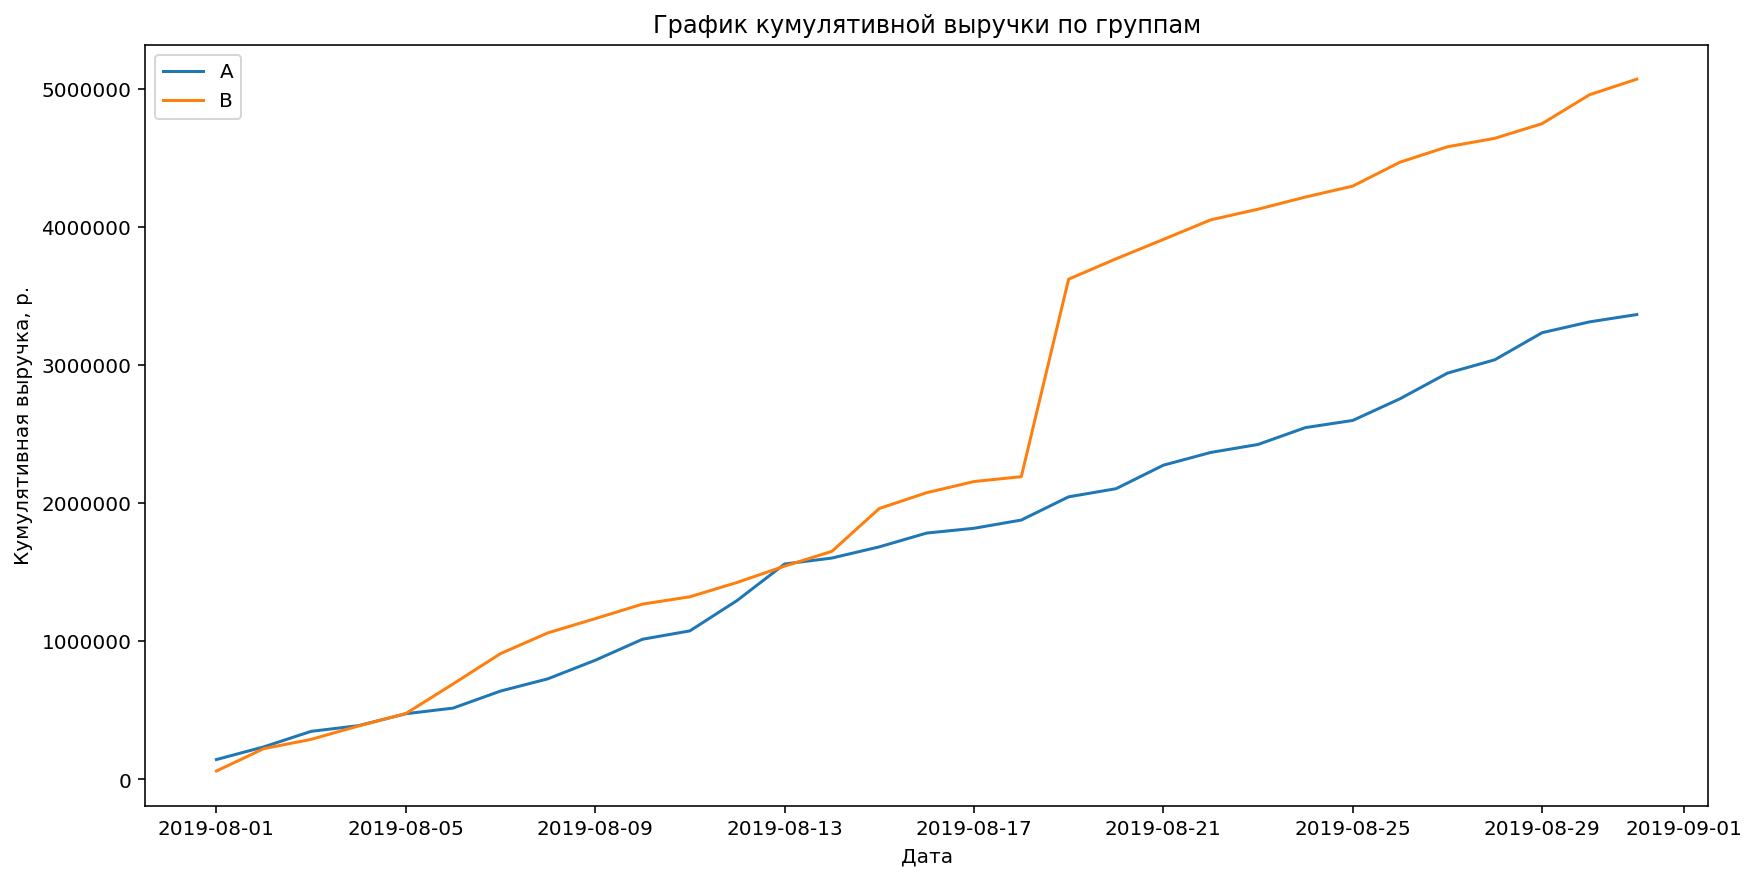

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(cum_data_a['date'], cum_data_a['revenue'], label='A')

plt.plot(cum_data_b['date'], cum_data_b['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, р.')
plt.show()

Графики выручки в течении всего срока проведения теста растут. Это хороший знак. Также необходимо отметить, что показатели выручки по группе В растут сильнее и к концу проведения теста опережают показатели по группе А примерно на 2 000 000. 

Также важно отметить резкий скачок графика В примерно в середине проведения теста, что может быть обусловленно выбросами. Это мы проанализируем позже.

Проанализировав графики кумулятивной выручки по группам, заключаем, что обе группы демострируют положительную динамику во времени с преимуществом по группе В, несмотря на явный всплеск. Что является положительным признаком.

## 2.4. Кумулятивный график среднего чека по группам.

Теперь построим график кумулятивного среднего чека по дням и группам.

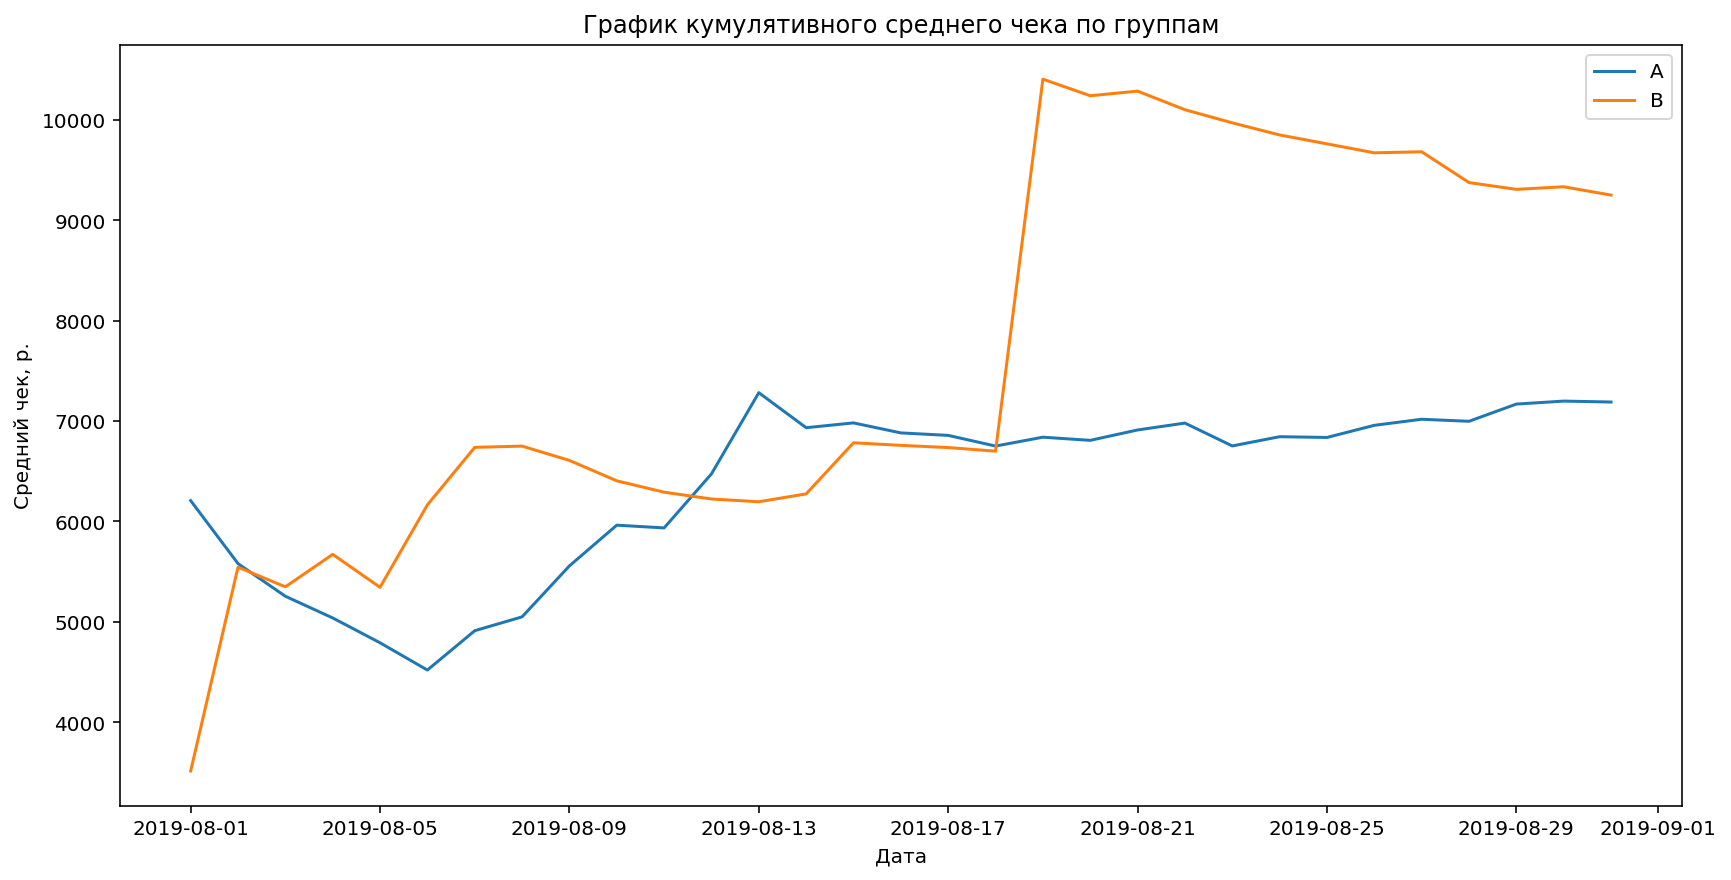

In [32]:
plt.figure(figsize=(14, 7))
plt.plot(cum_data_a['date'], cum_data_a['revenue']/cum_data_a['orders'], label='A')
plt.plot(cum_data_b['date'], cum_data_b['revenue']/cum_data_b['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Средний чек, р.')
plt.show()

На графиках мы видим следующее:

- график группы А болле равномерный, начиная с 13 числа установился в одном диапазоне;

- также отмечаем, что в первых числах проведения теста, график А имеет значительные спады и подъемы;

- график В тоже в первых числах колеблется, но не ярко выраженно и демонстрирует постоянное повышение;

- по графику В мы видим сильный скачок в середине, что может быть вызванно аномально большим заказом;

- после всплеска график В демонстрирует плавное снижение.

Также важно отметить, что средний чек за время теста вырос по обеим группам.

## 2.5. График относительного изменения кумулятивного среднего чека группы B к группе A.

Теперь проверим различия кумулятивного среднего чека группы В относительно к группе А.

Для этого объединим датафреймы с данным о кумулятивной выручки по группам в один.

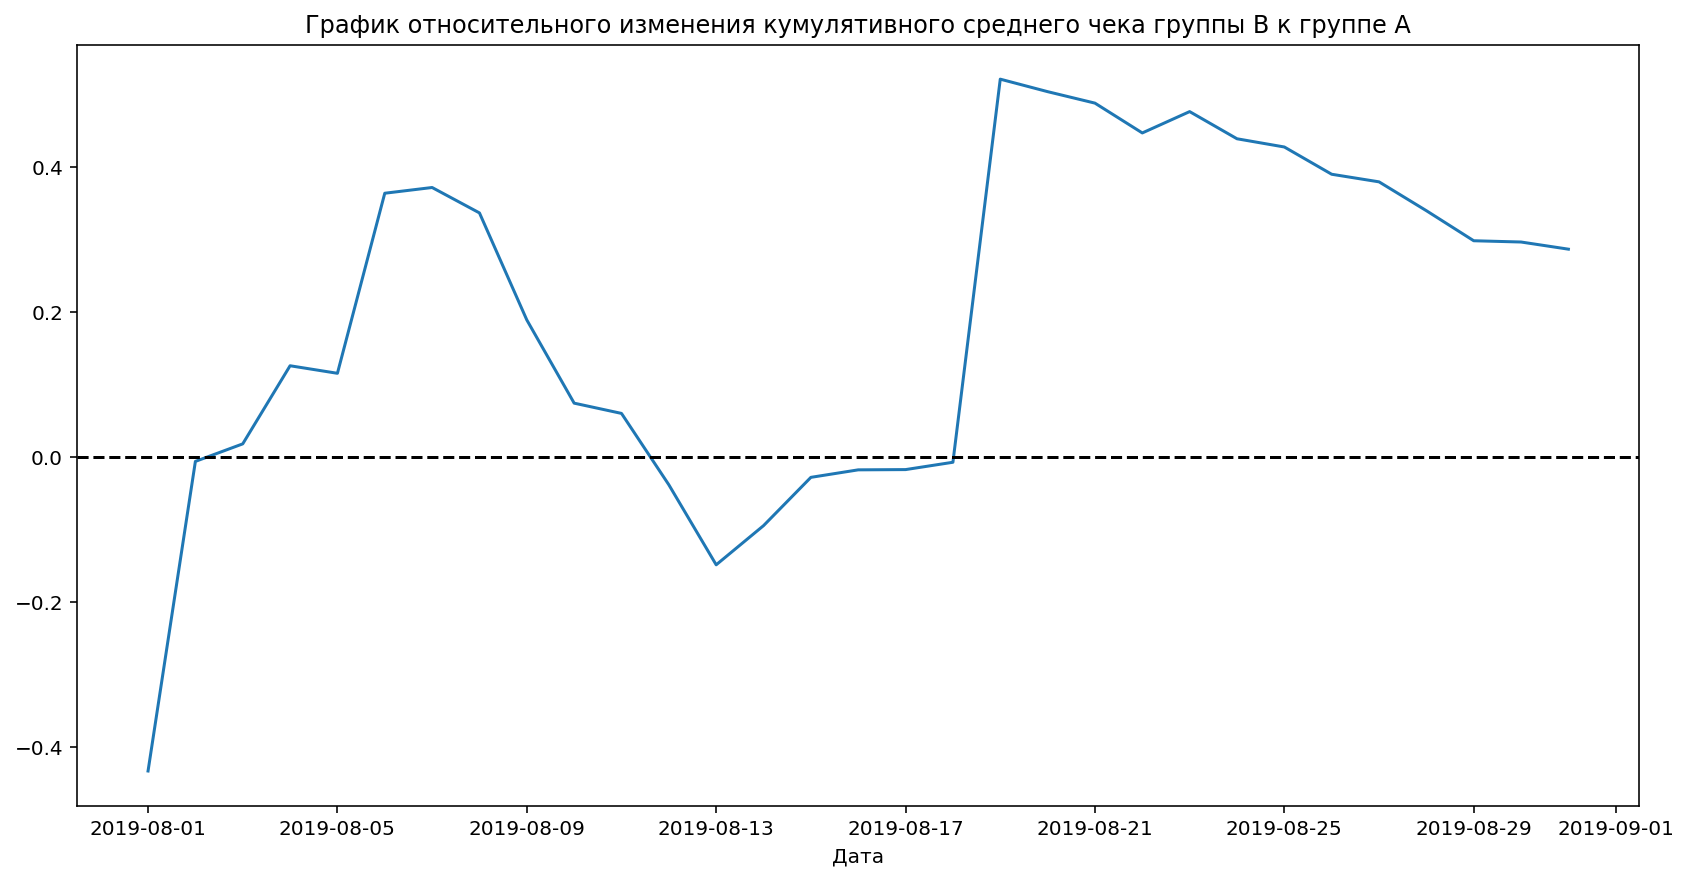

In [33]:
merged_cum_revenue = cum_revenue_a\
.merge(cum_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(14, 7))
plt.plot(merged_cum_revenue['date'],\
         (merged_cum_revenue['revenueB']/merged_cum_revenue['ordersB'])\
         /(merged_cum_revenue['revenueA']/merged_cum_revenue['ordersA'])-1)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel('Дата')
plt.show()

На графике мы видим, что график В пересекает значения графика А несколько раз за время проведения теста. Это с большой вероятностью вызванно аномальными заказами и всплесками. Но можно заметить, что ближе к концу график В демонстрирует снижение к графику А.

## 2.6. График кумулятивной конверсии по группам.

Проанализируем график кумулятивной конверсии по дням по и группам. Для этого нам необходимо задать максимальные и минимальные значения для осей Х и У.

Выведем на экран максимальные значения конверсии и даты начала и окончания теста по группам.

In [34]:
display(cum_data_a['conversion'].max())
display(cum_data_a['date'].max())
display(cum_data_a['date'].min())

0.03577235772357724

Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-01 00:00:00')

In [35]:
display(cum_data_b['conversion'].max())
display(cum_data_b['date'].max())
display(cum_data_b['date'].min())

0.031543731081726936

Timestamp('2019-08-31 00:00:00')

Timestamp('2019-08-01 00:00:00')

Зададим максимальные и минимальные значения оси Х как 01.08.2019 и 31.08.2019 соответственно. И максимальные и минимальные значения оси У как 0 и 0,05 соответственно.

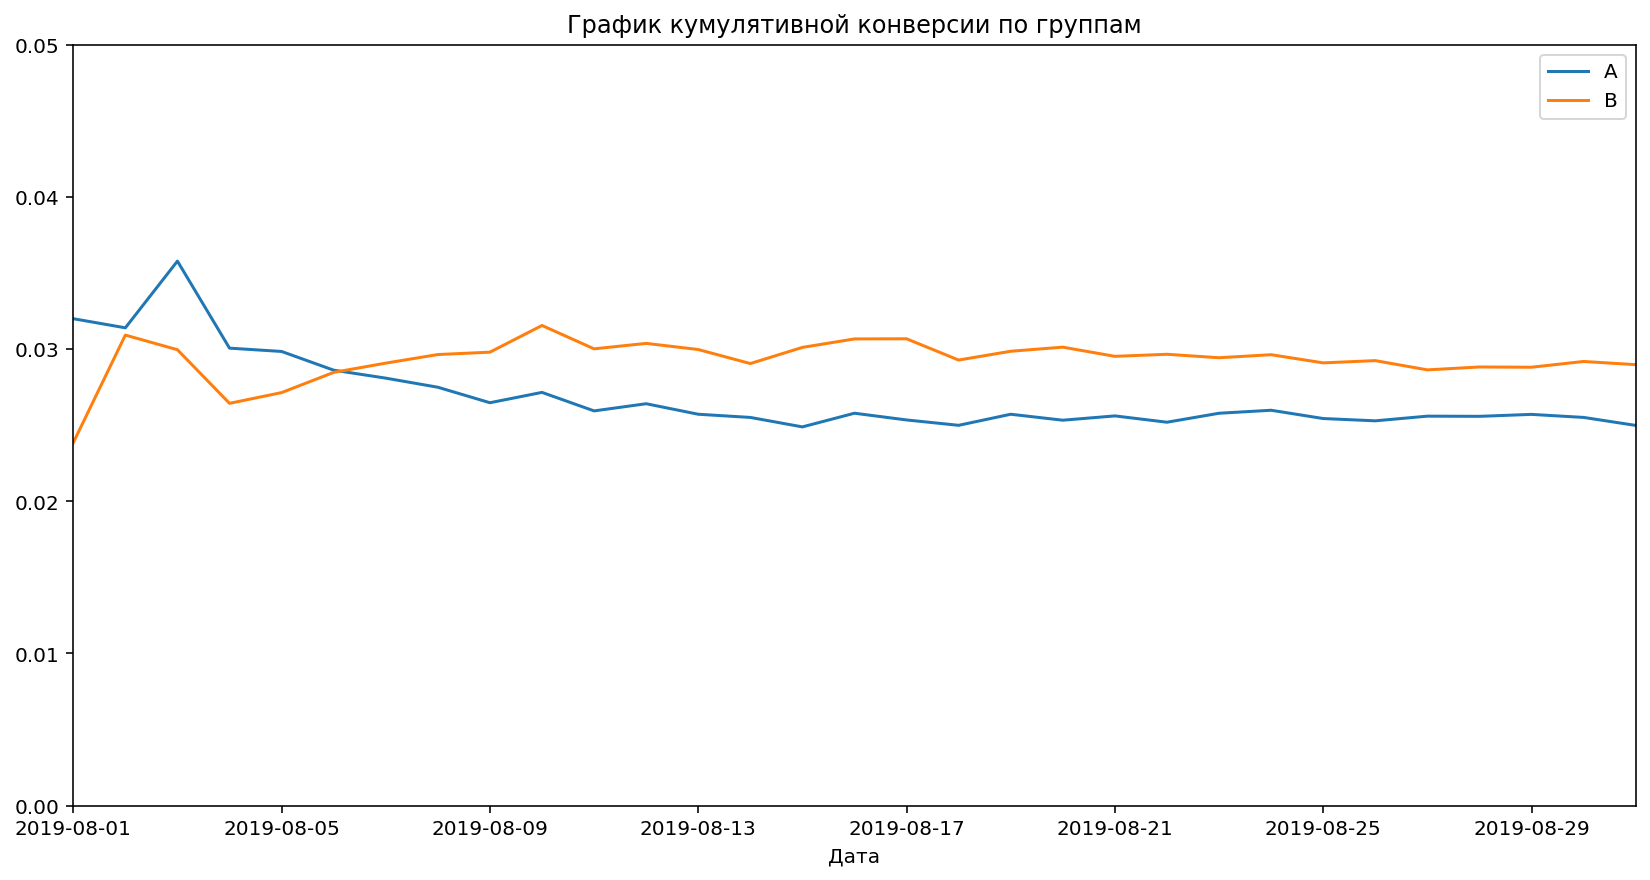

In [36]:
plt.figure(figsize=(14, 7))
plt.plot(cum_data_a['date'], cum_data_a['conversion'], label='A')
plt.plot(cum_data_b['date'], cum_data_b['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии по группам')
plt.axis(["2019-08-01", '2019-08-31', 0, 0.050]) 
plt.xlabel('Дата')
plt.show()

Мы видим на графиках, что в начале оба графика демонстрирует явные колебания и персекают друг друга. Затем начиная примерно с 09.08.2019 они выравниваются. При этом с момента устаканивания графиков конверсия по графику В находится всегда выше, чем по графику А.

Важно отметить, что конверсии обеих групп А и В довольно рано вышли на плато и демонстрируют очень стабильные показатели.

## 2.7. График относительного изменения кумулятивной конверсии группы B к группе A.

Построим график относительного различия кумулятивных конверсий.

Для этого соберем в одну таблицу данные с датами и конверсией по группам А и В.

In [37]:
merged_cum_conversions = cum_data_a[['date','conversion']]\
.merge(cum_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Построим график. Значения конверсии группы А зададим черной пунктирной линией и примем за 0. 

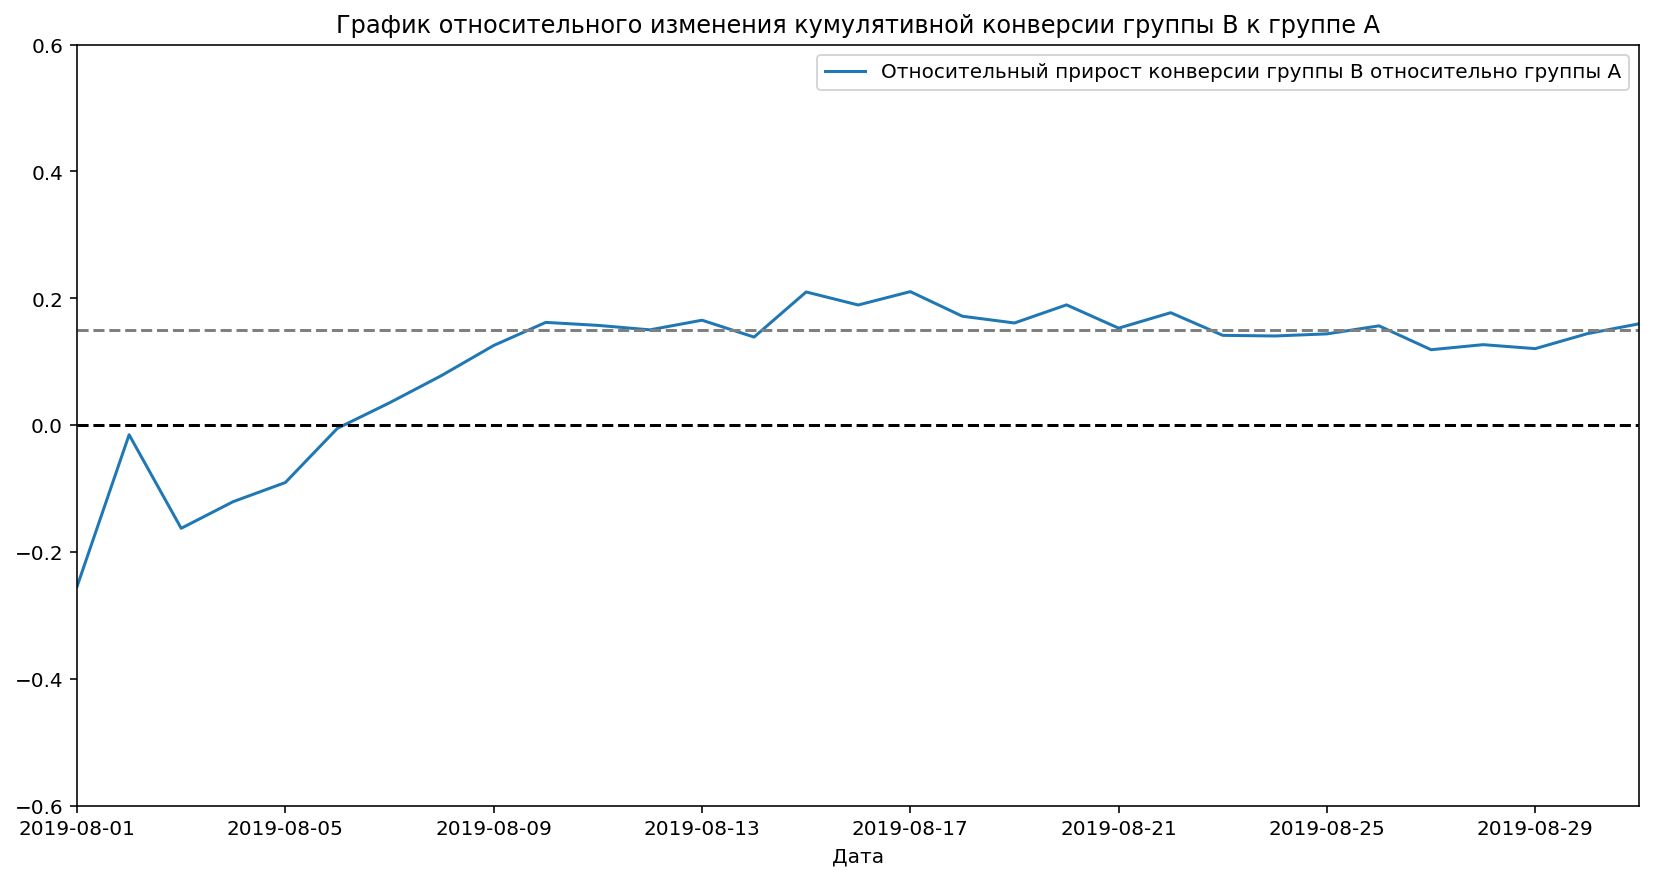

In [38]:
plt.figure(figsize=(14, 7))
plt.plot(merged_cum_conversions['date'],\
         merged_cum_conversions['conversionB']/merged_cum_conversions['conversionA']-1,\
         label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.6, 0.6]) 
plt.xlabel('Дата')
plt.show()

Здесь мы видим, что в начале теста конверсия группы В колебалась относительно группы А, потом уверенно стала больше примерно на 0,2. Начиная с 10.08.2019 конверсия группы В вышла на плато в районе значения 0,15 относительно конверсии группы А. 

Можем предварительно заключить, что различия конверсий относительно друг друга устоялись в пользу конверсии группы В.

## 2.8. Анализ выбросов и всплесков: количество заказов по пользователям.

Теперь приступим к анализу анамалий и выбросов, чтобы оценить их влияние на результаты теста.

In [39]:
orders.head(5)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


Посмотрим сколько в среднем пользователи делали заказов. Пользователи, совершившие много заказов, влияют на числитель формулы конверсии. Скорее всего, их поведение отличается от нормального.

In [40]:
orders_by_user = orders.\
groupby('visitorid', as_index=False).\
agg({'transactionid':'nunique'})
orders_by_user.columns = ['user_id', 'orders']
display(orders_by_user.sort_values(by='orders', ascending=False))

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
...,...,...
331,1438226485,1
332,1452540367,1
333,1455323168,1
334,1455861274,1


Мы видим, что после фильтрации количество заказов на одного пользователя не превышает трех. Посмотрим на их распределение на гистограмме.

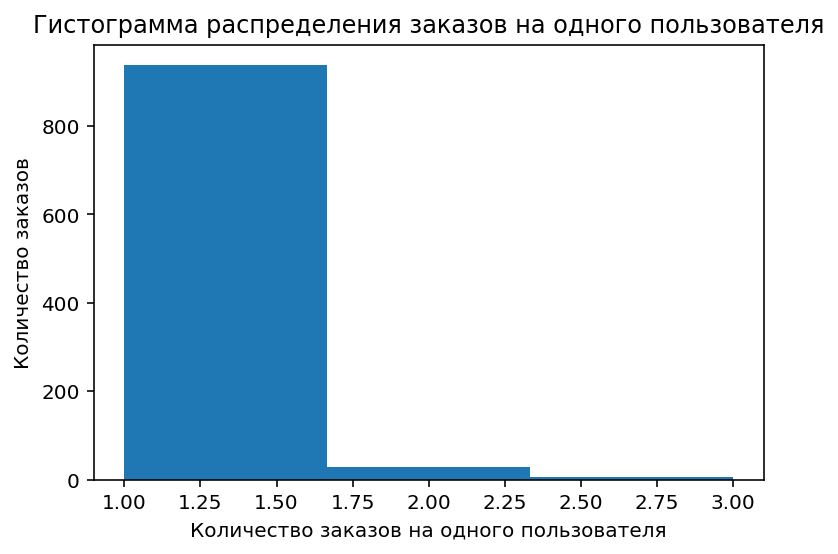

In [41]:
plt.hist(orders_by_user['orders'], bins=3) 
plt.xlabel('Количество заказов на одного пользователя')
plt.ylabel('Количество заказов')
plt.title('Гистограмма распределения заказов на одного пользователя')
plt.show()

Большинство пользователей совершает один заказ. Однако есть и доля пользователей, совершивших два и три заказа.

Построим точеченую диаграмму числа заказов на одного пользователя.

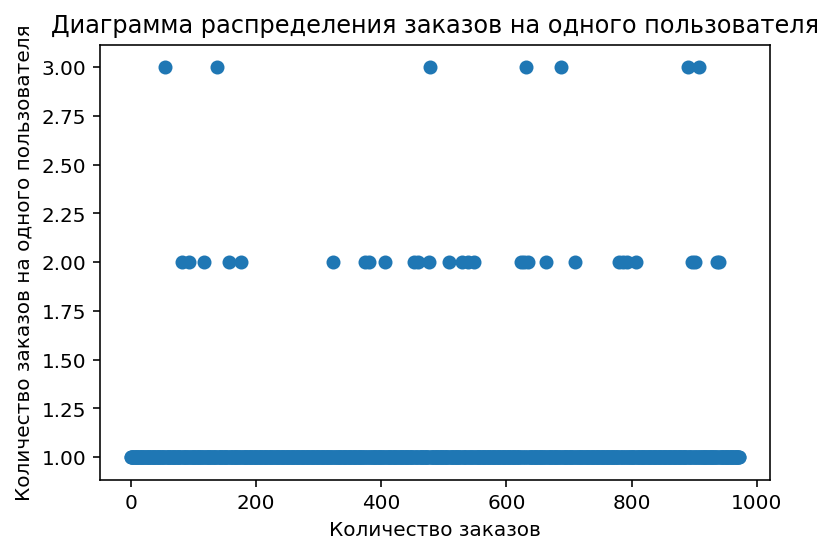

In [42]:
x_values = pd.Series(range(0,len(orders_by_user)))

plt.scatter(x_values, orders_by_user['orders'])
plt.xlabel('Количество заказов')
plt.ylabel('Количество заказов на одного пользователя')
plt.title('Диаграмма распределения заказов на одного пользователя')
plt.show()

Выводы подтверждаются: много пользователей совершивших 2 и 3 заказа. Для точного определения, какое количество заказов считать аномалиями, а какое нет, посчитаем 95 и 99 перцентили количества заказов на одного пользователя.

In [43]:
np.percentile(orders_by_user['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей оформляли больше одного заказа и не больше 1% оформили больше двух заказов.

Логично выбрать границу отсечения аномальных заказов больше 1.

## 2.9. Анализ выбросов и всплесков: стоимость заказов.

Таким же способом отфильтруем аномальные заказы по стоимости.

Посмотрим на максимальные значения стоимости заказов.

In [44]:
display(orders.sort_values(by='revenue', ascending=False).head(5))

,transactionid,visitorid,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A


Мы видим, что пользователями были совершены очень крупные покупки на суммы болле 200 000 р и почти 1 300 000 р. Эти заказы как раз были выполнены пользователями из группы В, что и давало всплески на наших графиках в сторону группы В ранее.

Построим гистограмму распределения стоимости заказов.

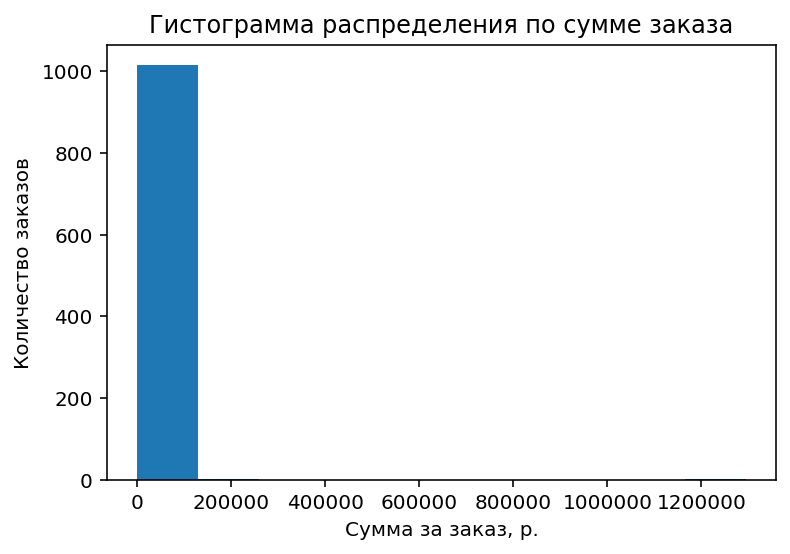

In [45]:
plt.hist(orders['revenue']) 
plt.xlabel('Сумма за заказ, р.')
plt.ylabel('Количество заказов')
plt.title('Гистограмма распределения по сумме заказа')
plt.show()

Здесь мы видим подтверждение, что подавляющая часть заказов не превышает по стоимости 100 000 р.

Для подтверждения построим точечную диаграмму распределения стоимости заказов.

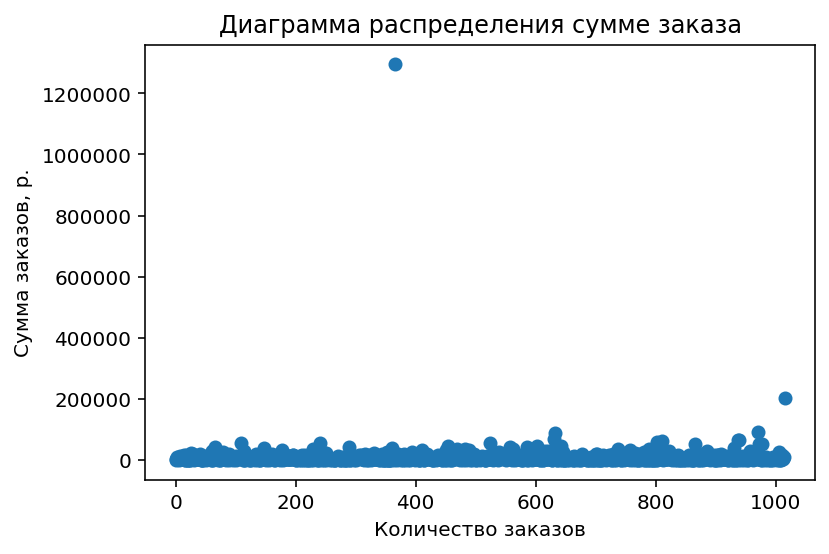

In [46]:
x_values = pd.Series(range(0,len(orders)))

plt.scatter(x_values, orders['revenue'])
plt.xlabel('Количество заказов')
plt.ylabel('Сумма заказов, р.')
plt.title('Диаграмма распределения сумме заказа')
plt.show()

Всего два выброса, зафиксированных нами ранее, но как они влияли на поведение графиков по группам. 

Определим 95 и 99 персентили для стоимости заказов.

In [47]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Только 5% пользователей заплатили более 27 000 р и лишь 1% пользователей заплатил более 54 000 р.

Определим границу отсечения аномальных заказов на уровне 27 000 р.

## 2.10. Статистическая значимость различий в конверсии между группами по «сырым» данным.

На предыдущих шагах мы:

- Оценили результаты A/B-теста визуально и выяснили, что в данных есть выбросы;

- выявили выбросы и нашли границу для их определения.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Для этого сформулируем гипотезы.
- **Н0: различий в конверсии между группами нет.**

- **Н1: различия в конверсии между группами есть.**

Приступим к оценке статистической значимости различий в конверсии между группами по «сырым» данным.

Начнём с подготовки данных.

Соберем в один датафрейм `data` данные о количестве заказов и их стоимости, а также о количестве пользователей  на выбранную дату. Данные о суммарной выручке и числе заказов на выбранную дату.

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [48]:
#Создадим датафреймы с разбивкой пользователей по группам
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']
#Посчитаем кумулятивное количество пользователей
visitors_a_cum = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cum.columns = ['date', 'visitors_cum_a']
#Тоже самое для группы В
visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cum = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cum.columns = ['date', 'visitors_cum_b']
#Создадим датафреймы с разбивкой по группам с данными о заказах и оплатах
orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']
#Посчитаем кумулятивные значения для каждой группы
orders_a_cum = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cum.columns = [
    'date',
    'orders_cum_a',
    'revenue_cum_a',
]
#Тоже самое для группы В
orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cum = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cum.columns = [
    'date',
    'orders_cum_b',
    'revenue_cum_b',
]
#Объединим все данные в один датафрейм
data = (orders_a_daily.merge(orders_b_daily, left_on='date', right_on='date', how='left')
    .merge(orders_a_cum, left_on='date', right_on='date', how='left')
    .merge(orders_b_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cum, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cum, left_on='date', right_on='date', how='left')
)
#Создадим датафреймы с количеством заказов для каждого пользователя, сделавшего хотя бы один заказ
orders_by_user_a = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_by_user_a.columns = ['userId', 'orders']

orders_by_user_b = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_by_user_b.columns = ['userId', 'orders']
#Создаем переменные с количеством заказов для пользователей из разных групп 
sampleA = pd.concat([orders_by_user_a['orders'],\
                     pd.Series(0, index=np.arange(data['visitors_per_date_a'].\
                                                  sum() - len(orders_by_user_a['orders'])), name='orders')],axis=0)
sampleB = pd.concat([orders_by_user_b['orders'],\
                     pd.Series(0, index=np.arange(data['visitors_per_date_b'].\
                                                  sum() - len(orders_by_user_b['orders'])), name='orders')],axis=0)

Посчитаем статистическую значимость различия в конверсии между группами.

Выведем относительный прирост конверсии группы B. Округлим до трёх знаков после запятой.

In [49]:
print("{0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.00551
0.160


Значение p-value значительно меньше 0,05, поэтому **нулевую гипотезу отвергаем.**

Анализ "сырых" данных говорит о том, что в конверсии между группами есть статистически значимые различия.

Относительный прирост конверсии группы В к группе А равен 16%.

## 2.11. Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 
Также свормулируем две гипотезы: 

- **Н0: различий в среднем чеке между группами нет**; 

- **Н1: различия в среднем чеке между группами есть**.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.

А ещё найдём относительные различия в среднем чеке между группами.

In [50]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
                                          orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].\
                       mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.415
0.287


P-value значительно выше 0,05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

Наблюдаемое различие в 29% в среднем чеке между группами не является статистически значимым и обучловленно большими аномальными значениями по группе В.

## 2.12. Статистическая значимость различий в конверсии между группами по «очищенным» данным.

Ранее мы обозначили границы отсечения аномальных значений по количесвту заказов и их стоимости.

Поэтому примем за границу отсечения пользователей, которые сделали больше 1 заказов и заплатилы более 27 000 р.

In [51]:
users_with_many_orders = pd.concat([orders_by_user_a[orders_by_user_a['orders'] > 1]['userId'],
                                    orders_by_user_b[orders_by_user_b['orders'] > 1]['userId']], axis=0)

users_with_expensive_orders = orders[orders['revenue'] > 27000]['visitorid']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. 

Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [52]:
sample_a_filt = pd.concat([orders_by_user_a[np.logical_not(orders_by_user_a['userId'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_user_a['orders'])),
        name='orders')], axis=0)

sample_b_filt = pd.concat([orders_by_user_b[np.logical_not(orders_by_user_b['userId'].isin(abnormal_users))]['orders'],
        pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_user_b['orders'])),
        name='orders')], axis=0) 

Снова сформулируем две гипотезы:

- **Н0: различий в конверсии между группами нет.**

- **Н1: различия в конверсии между группами есть.**

Применим статистический критерий Манна-Уитни к полученным выборкам, а также выведем относительный прирост конверсии группы B.

In [53]:
print('{0:.5f}'.format(st.mannwhitneyu(sample_a_filt, sample_b_filt)[1]))
print('{0:.3f}'.format(sample_b_filt.mean()/sample_a_filt.mean()-1)) 

0.00797
0.174


Как и в случае с "сырыми" данными, значение p-value значительно меньше 0,05. **Нулевую гипотезу отвергаем.** Между выборками есть статистически значимые различия.

Конверсия группы В на 17,4% выше, чем конверсия группы А.

## 2.13. Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами после очистки данных. 
Также свормулируем две гипотезы: 

- **Н0: различий в среднем чеке между группами нет**; 

- **Н1: различия в среднем чеке между группами есть**.

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.

А ещё найдём относительные различия в среднем чеке между группами.

In [54]:
print('{0:.3f}'.\
      format(st.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',\
                                  np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'],\
                                  orders[np.logical_and(orders['group'] == 'B',\
                                  np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'],)[1])
)

print('{0:.3f}'.\
      format(orders[np.logical_and(orders['group'] == 'B',\
                                np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',\
                                np.logical_not(orders['visitorid'].isin(abnormal_users)))]['revenue'].mean() - 1)
) 

0.364
-0.034


В этом случае также, как и по результатам с "сырыми" данными, значение p-value значительно больше 0,05. **Не можем отвергнуть нулевую гипотезу.** Значимых различий в среднем чеке между группами нет.

Однако существенно изменилась разница в среднем чеке по результатам очистки данных от выбросов: теперь значения практически равны с небольшим преимуществом в 3% в пользу среднего чека по группе А.

Удаление аномалий не сильно сказалось на выводах по результатам анализа, не считая, что средний чек по очищенным данным между группами А и В не имеет различий.

Можем сформулировать все полученные нами выводы:

- имеются статистически значимые различия в конверсии между группами как по "сырым", так и по очищенным данным, в пользу группы В;

- по очищенным данным различия в конверсии в пользу группы В больше, чем по "сырым" данным - 17% против 14%;

- отсутствуют статистически значимые различия в среднем чеке между группами как по "сырым", так и по очищенным данным;

- средний чек по группе В по "сырым" данным выше среднего чека группы А на 26%, а по очищееным данным средние чеки практически равны с перевесом в 2% в пользу среднего чека группы А. Это говорит о том, что выявленные нами аномальные по стоимости заказы существенным образом оказывают влияние на значения среднего чека, не меняя его общего поведения;

- график различия конверсий между группами показывает, что конверсия группы В стабильно выше конверсии группы А, и пока не приходится говорить о изменении наметившейся тенденции;

- график различия среднего чека говорит, что разница между группами вызванна двумя аномально дорогими заказами, при очистке от которых значения не показывают большой разницы.

# 3. Общие выводы.

Суммируя все полученные нами ранее выводы, заключаем следующее: **тест можно признать успешным, различия по конверсии групп явно лучше у пользователей группы В, стабильны и не имеют предпосылок к ухудшению, значительной разницы в средних чека после очистки данных не наблюдается.**

Существенное различие в среднем чеке между группами можно смело списать на аномально большие покупки, совершенные пользователями группы В.

